# Invertible Neural Networks (for generation)

In [1]:
import jax 
import jax.numpy as np
import jax.scipy as sp
from jax import value_and_grad, grad, jit, vmap
from jax.example_libraries import optimizers
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

plt.style.use('dark_background')
background_color = tuple(onp.array([66, 68, 69])/255)
plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['figure.facecolor'] = background_color

$$\frac{|| f(x_0) - f(x_1) ||}{||x_0 - x_1||} < q \qquad \forall_{x_0, x_1 \in X}$$
$$ z = f(x) + x $$
$$ x = z - f(x) $$
$$ x = z - f(z - f(x))$$
$$ x = z - f(z - f(\dots))$$

Is $g(x) = z - f(x)$ a contraction? 

$$|| g(x_0) - g(x_1) || = || z - f(x_0) - z + f(x_1) || $$
$$ = || f(x_1) - f(x_0) || = $$
$$ = || f(x_1) - f(x_0) || < q ||x_0 - x_1|| $$

Therefore, $g$ is a contraction. 


<!-- $$ p(f | D) = \frac{p(D | f)p(f)}{p(D)} \propto p(D | f)p(f) $$
$$ \mathbb{D}_{KL}[q(f)\;||\;p(f | D)] = -\mathbb{E}_{f \sim q, X \sim \mathcal{X}}\text{log}(f(X)) + \mathbb{D}_{KL}[q(f) \;||\;p(f)]$$
Easier, not accurate:
$$ \max_{\theta \in \Theta} \mathbb{E}_{X\sim\mathcal{X}}\text{log}\,m_\theta(X) $$
$$ \text{s.t. } \forall_{w \in W} ||w||_2 < q $$
where $0 \leq q < 1$ and $W \subset \theta$ are the weights of the neural network. The problem is, that we need to sample from the approximate distribution, and we do not want that. 
 -->
We want to minimise relative entropy between true and approximate distributions: 
$$ \mathbb{D}_{KL}(p(X) \;||\; q_\theta(X) ) = \mathbb{E}_{X \sim p}\text{log}p(X) - \mathbb{E}_{X \sim p}\text{log}q_\theta(X)$$
For minimization, entropy of the real data is unimportant, as it is independent of $\theta$, hence we minimize only the crossentropy:
$$ \min_{\theta \in \Theta}  - \mathbb{E}_{X \sim p}\text{log}q_\theta(X) $$
$$ \text{s.t. } \forall_{w \in W} ||w||_2 < q $$
where $0 \leq q < 1$ and $W \subset \theta$ are the weights of the neural network. Notice, that we now sample from the data distribution, i.e., we sample from our dataset.

In [119]:
def sample_data(key, n, s=0.0):
    R = jax.random.normal(key, shape=(n, 3))
    return (R[:, 0].reshape(-1,1) + 3) * np.c_[np.sin(1*R[:,0]), np.cos(1*R[:,0])] + s*R[:, 1:]

In [120]:
key = jax.random.PRNGKey(1022023)
X = sample_data(key, 1000, 0.2)

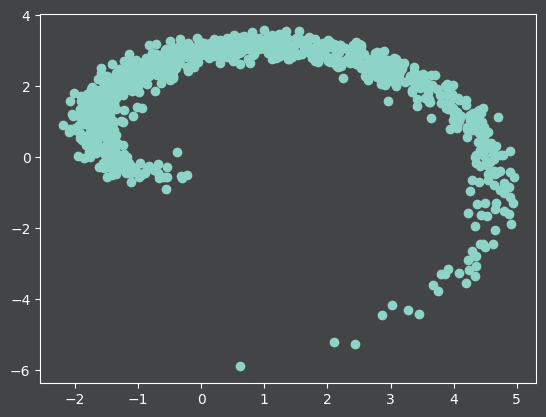

In [121]:
plt.scatter(X[:,0], X[:,1])

In [122]:
def value_and_jacrev(f, x):
    y, pullback = jax.vjp(f, x)
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = jax.vmap(pullback)(basis)
    return y, jac

def create_layer(key, input_dim, output_dim):
    weight = jax.random.normal(key, shape=(input_dim, output_dim))/input_dim
    bias = np.zeros((output_dim, ))
    return weight, bias

def create_mlp(key, inout):
    return [create_layer(key, inout[i], inout[i+1])
            for i, key in enumerate(jax.random.split(key, len(inout)-1))]

def layer_forward(layer, activation_function, X):
    weight, bias = layer
    return activation_function(X @ weight + bias)

def residual_forward(layer, activation_function, X):
    return layer_forward(layer, activation_function, X) + X

def forward(params, X):
    for i, layer in enumerate(params):
        activation_function = jax.nn.relu if i < len(params)-1 else lambda x: x
        X = residual_forward(layer, activation_function, X)
    return X

def layer_constraint(layer):
    weight, _ = layer
    return jax.nn.relu(np.linalg.norm(weight, ord=2) - 1)

def constraint(params):
    return sum(layer_constraint(layer) for layer in params)

def log_density(params, X):
    
    Z, pullback = jax.vjp(lambda X: forward(params, X), X)
    
    basis = np.eye(Z.shape[1], dtype=Z.dtype)[:,np.newaxis,:].repeat(Z.shape[0], axis=1)
    jac = vmap(pullback)(basis)[0].transpose((1,0,2))
    
    # print(jac.shape)
    # print(np.linalg.det(jac[0,:,:]))
    # print(vmap(np.linalg.det)(jac))
    
    return sp.stats.norm.logpdf(Z).sum(axis=1) + np.log(np.abs(jax.vmap(np.linalg.det)(jac)))

def loss(params, X, C):
    weights = [p[0] for p in params]
    return -log_density(params, X).sum() + C*constraint(params)

In [123]:
key = jax.random.PRNGKey(1022023)
params = create_mlp(key, [2,2,2,2,2,2,2,2,2,2])
losses = []

In [124]:
learning_rate=0.001
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

In [ ]:
key = jax.random.PRNGKey(1022023)
EPOCHS = 10000
batch_size = 128*4
C = 10000.5

for epoch in (pbar := trange(EPOCHS)):
    
    key, subkey = jax.random.split(key)
    X = sample_data(key, batch_size, 0.2)
    value, grads = jax.value_and_grad(lambda params: loss(params, X, C))(get_params(opt_state))
    opt_state = opt_update(epoch, grads, opt_state)
    
    losses.append(value)
    pbar.set_description(f"{value:0.03f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [136]:
constraint(get_params(opt_state))

Array(0.01662183, dtype=float32)

In [137]:
layer_constraint(get_params(opt_state)[3])

Array(0.01662183, dtype=float32)

In [138]:
key = jax.random.PRNGKey(1022023)
Z = jax.random.normal(key, shape=(1000,2))

In [139]:
def residual_backward(layer, activation_function, Z, n=10):
    Z_prev = Z
    for _ in range(n):
        Z_prev = Z - layer_forward(layer, activation_function, Z_prev)
    return Z_prev
def backward(params, Z, n=10):
    for i, layer in enumerate(reversed(params)):
        activation_function = jax.nn.relu if i > 0 else lambda x: x
        Z = residual_backward(layer, activation_function, Z, n)
    return Z

In [140]:
Xhat = backward(get_params(opt_state), Z)

In [141]:
Xhat

Array([[   2.4800563,    0.4500417],
       [ -88.42135  ,  -86.27168  ],
       [   3.5003061,    1.5303614],
       ...,
       [   3.3240345,    3.5440662],
       [-191.56783  , -190.13496  ],
       [  -1.014482 ,    3.7142394]], dtype=float32)

(-6.0, 6.0)

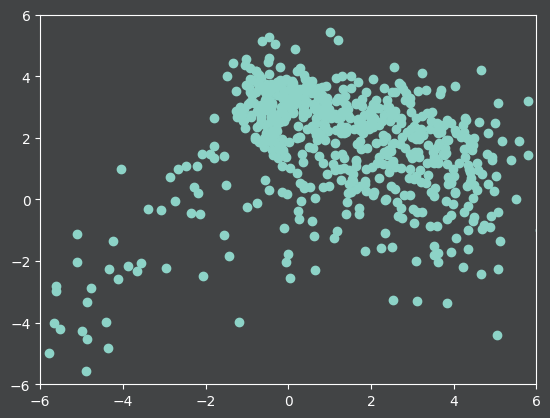

In [144]:
plt.scatter(Xhat[:,0], Xhat[:,1])
plt.xlim(-6,6)
plt.ylim(-6,6)